In [1]:
# setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex2 import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# load dataset
df = pd.read_csv("../input/fe-course-data/ames.csv")

#function to calc. MI-scores for each features-> return MI score arr with index
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # all discrete features should have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#plot 'barh' of MI-scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

/tmp/ipykernel_42/1913343937.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [31]:
X = df.copy()
y = X.pop("SalePrice") 
make_mi_scores(X,y)

0       1960
1       1961
2       1958
3       1968
4       1997
        ... 
2925    1984
2926    1983
2927    1992
2928    1974
2929    1993
Name: YearBuilt, Length: 2930, dtype: int64

-------------------------------------------------------------------------------

Let's review the meaning of **Mutual Information** by looking at a few features from the `Ames` dataset.

In [56]:
df.melt(id_vars="SalePrice", value_vars=features)

,SalePrice,variable,value
0,215000,YearBuilt,1960.0
1,105000,YearBuilt,1961.0
2,172000,YearBuilt,1958.0
3,244000,YearBuilt,1968.0
4,189900,YearBuilt,1997.0
...,...,...,...
8785,142500,ScreenPorch,0.0
8786,131000,ScreenPorch,0.0
8787,132000,ScreenPorch,0.0
8788,170000,ScreenPorch,0.0


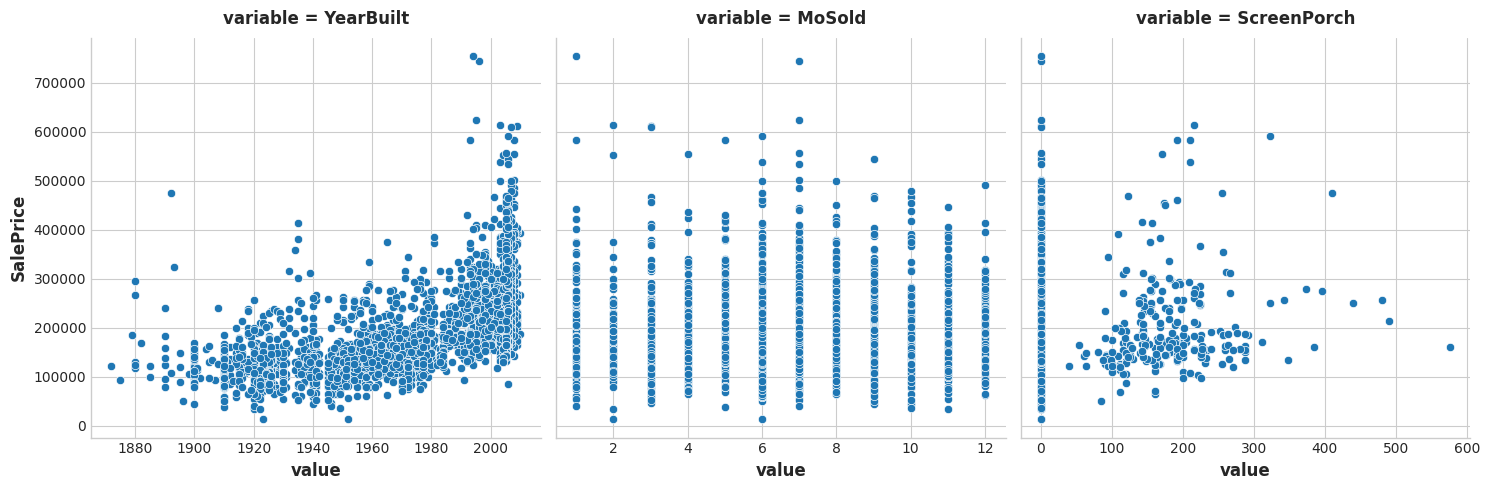

In [2]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
); #col: create separate columns for different categorical variable

# Understanding Mutual Information
-------------------------------------------------------------------------------

Based on the plots,`YearBuilt` should have the highest MI score since knowing the year tends to constrain `SalePrice` to a smaller range of possible values.

The Ames dataset has seventy-eight features -- a lot to work with all at once! Fortunately, we can identify the features with the most potential.

Using the make_mi_scores function to compute mutual information scores for the Ames features:

In [57]:
#generate MI scores for each features
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)
mi_scores.filter(regex='^B')

BsmtQual        0.364779
BsmtFinType1    0.190645
BsmtFinSF1      0.187448
BsmtUnfSF       0.114200
BsmtExposure    0.100871
BsmtCond        0.051208
BldgType        0.050671
BedroomAbvGr    0.049425
BsmtFullBath    0.048202
BsmtFinType2    0.028260
BsmtHalfBath    0.013719
BsmtFinSF2      0.000000
Name: MI Scores, dtype: float64

Now we can examine the scores using the MI-function, looking at the top and bottom ranks.

Top 20 MI Scores: 
 
 OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


 Bottom 20 MI Scores: 
 
 ExterCond           0.020934
KitchenAbvGr        0.017677
BsmtHalfBath        0.013719
LotConfig           0.013637
ScreenPorch         0.012981
PoolArea            0.012831
MiscVal             0.010997
LowQualFinSF        0.009328
Heating             0.007622
Functional          0.006380
MiscFeature         0.004322
Street              0.003381
Condition2          0.003176
RoofMatl            0.002620
PoolQC      

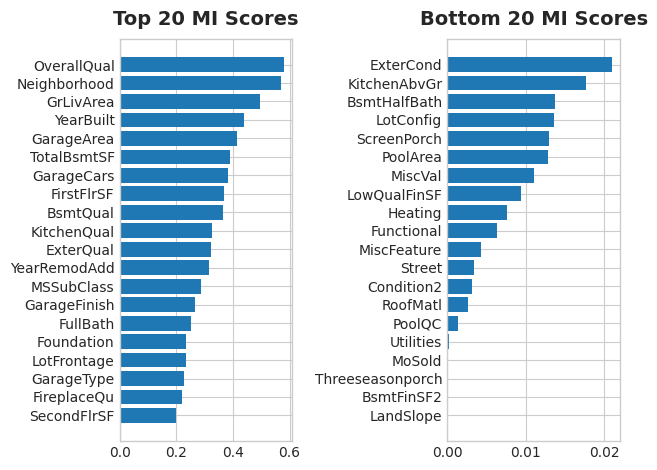

In [58]:
#check top & bottom MI scores

print(f'Top 20 MI Scores: \n \n {mi_scores.head(20)}\n')
print(f'\n Bottom 20 MI Scores: \n \n {mi_scores.tail(20)}') 

plt.subplot(1,2,1)
plot_mi_scores(mi_scores.head(20))
plt.title('Top 20 MI Scores')

plt.subplot(1,2,2)
plot_mi_scores(mi_scores.tail(20))  
plt.title('Bottom 20 MI Scores')

plt.tight_layout()

### Themes of the features:

Some common themes among most of these features are:

Location: `Neighborhood`

Size: all of the `Area` and `SF` features, and counts like `FullBath` and `GarageCars`

Quality: all of the `Qual` features

Year: `YearBuilt` and `YearRemodAdd`

Types: descriptions of features and styles like `Foundation` and `GarageType`

It's good that our MI-metric scored them highly. On the other hand, the lowest ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't be relevant to the average home buyer.

# Investigate Interactions:
-------------------------------------------------------------------------------

In this step we'll investigate possible interaction effects for the `BldgType` feature. This feature describes the broad structure of the dwelling in five categories:

> Bldg Type (Nominal): Type of dwelling
>		
>       1Fam	Single-family Detached	
>       2FmCon	Two-family Conversion; originally built as one-family dwelling
>       Duplx	Duplex
>       TwnhsE	Townhouse End Unit
>       TwnhsI	Townhouse Inside Unit

The `BldgType` feature didn't get a very high MI score. A plot confirms that the categories in `BldgType` don't do a good job of distinguishing values in `SalePrice` (the distributions look fairly similar, in other words):

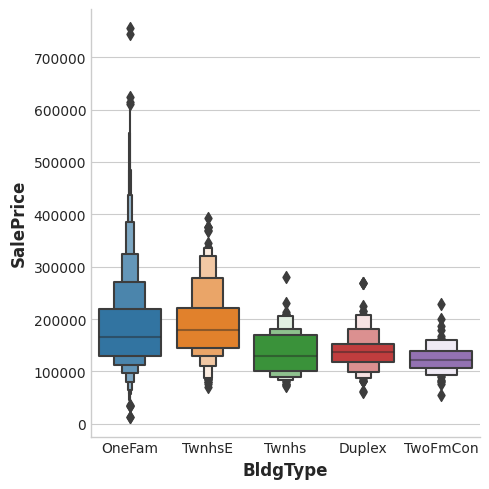

In [40]:
#categorical plots
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information. We investigated whether `BldgType` produces a significant interaction with either of the following:

`GrLivArea`  # Above ground living area

`MoSold`     # Month sold




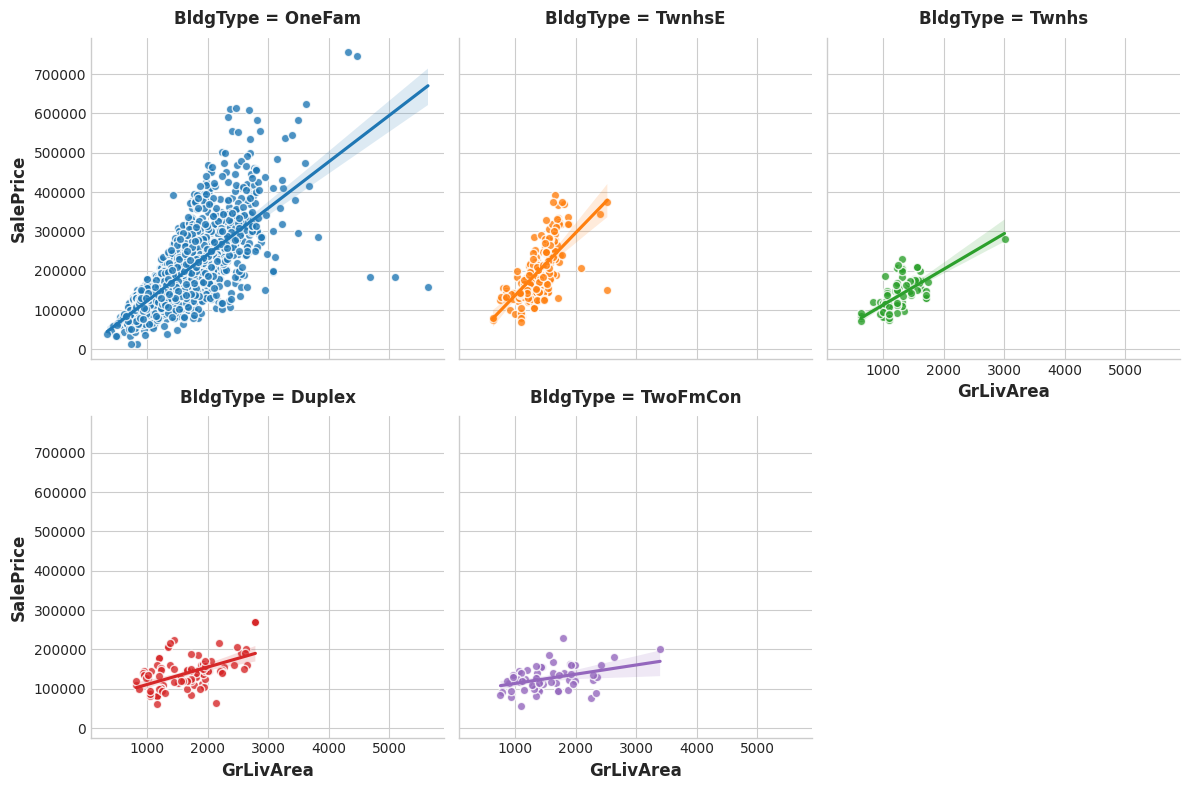

In [61]:
feature = "GrLivArea"
sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category (`GrLivArea`) to the next (`MoSold`) indicates an interaction effect.

# Discover Interactions

From the plots, we figure out if `BldgType` exhibit any interaction effect with either `GrLivArea` or `MoSold`: 

The trends lines within each category of `BldgType` are clearly very different, indicating an interaction between these features. Since knowing `BldgType` tells us more about how `GrLivArea` relates to `SalePrice`, we should consider including `BldgType` in our feature set.

The trend lines for `MoSold`, however, are almost all the same. This feature hasn't become more informative for knowing `BldgType`.

# A First Set of Development Features #

We make a list of features we should focus on.  We found that the ten features with the highest MI scores were:

In [59]:
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

Combining these top features with other related features, especially those we've identified as creating interactions, is a good strategy for coming up with a highly informative set of features to train our model on.
